#### Transfer Learning + Image Data Augmentation + Early Stopping
monitoring fbeta

#### monitor fbeta instead of loss and save model

In [1]:
import os, sys


import pandas as pd
pd.options.display.max_rows

import numpy as np
from numpy import ones
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from numpy import load

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import fbeta_score


from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend
from keras.optimizers import SGD

import cv2

Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import tensorflow as tf

import h5py

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [5]:
# load train and test dataset
def load_dataset():
    # load dataset
    data = load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY


# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [6]:
%%time

# vgg16 transfer learning on the planet dataset

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable -- fine tuning
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Fbeta')
	plt.plot(history.history['fbeta'], color='blue', label='train')
	plt.plot(history.history['val_fbeta'], color='orange', label='test')



In [8]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    
    es = EarlyStopping(monitor = 'fbeta', mode='max', verbose=1, patience = 5)
    mc = ModelCheckpoint('best_model_acc.h5', monitor='val_accuracy', mode='max', verbose=1)
    
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1, callbacks = [es, mc])
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0 )
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)

Epoch 00001: saving model to best_model_acc.h5

Epoch 00002: saving model to best_model_acc.h5

Epoch 00003: saving model to best_model_acc.h5

Epoch 00004: saving model to best_model_acc.h5

Epoch 00005: saving model to best_model_acc.h5

Epoch 00006: saving model to best_model_acc.h5

Epoch 00007: saving model to best_model_acc.h5

Epoch 00008: saving model to best_model_acc.h5

Epoch 00009: saving model to best_model_acc.h5

Epoch 00010: saving model to best_model_acc.h5

Epoch 00011: saving model to best_model_acc.h5

Epoch 00012: saving model to best_model_acc.h5

Epoch 00013: saving model to best_model_acc.h5

Epoch 00014: saving model to best_model_acc.h5

Epoch 00015: saving model to best_model_acc.h5

Epoch 00016: saving model to best_model_acc.h5

Epoch 00017: saving model to best_model_acc.h5

Epoch 00018: saving model to best_model_acc.h5

Epoch 00019: saving model to best_model_acc.h5

Epoch 00020: saving m

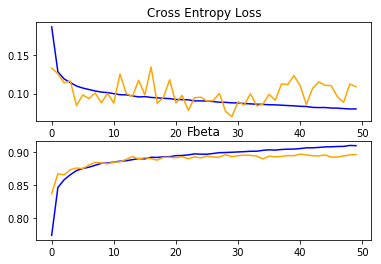

In [9]:
%%time

# entry point, run the test harness
run_test_harness()
